# Network Analysis - The Danish Power Elites

### Import and Manipulate Data

In [1]:
# Import Libraries

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
import community.community_louvain as community_louvain

sns.set()

In [2]:
# Import Dataset

df = pd.read_csv('https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/00_data/networks/elite_den17.csv')

In [3]:
# Inspect Dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56849 entries, 0 to 56848
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NAME             56849 non-null  object 
 1   AFFILIATION      56849 non-null  object 
 2   ROLE             54312 non-null  object 
 3   TAGS             54809 non-null  object 
 4   POSITION_ID      56849 non-null  int64  
 5   ID               56849 non-null  int64  
 6   SECTOR           54500 non-null  object 
 7   TYPE             36116 non-null  object 
 8   DESCRIPTION      47785 non-null  object 
 9   CREATED          56828 non-null  object 
 10  ARCHIVED         0 non-null      float64
 11  LAST_CHECKED     56820 non-null  object 
 12  CVR_PERSON       23659 non-null  float64
 13  CVR_AFFILIATION  23712 non-null  float64
 14  PERSON_ID        56849 non-null  int64  
 15  AFFILIATION_ID   56849 non-null  int64  
dtypes: float64(3), int64(4), object(9)
memory usage: 6.9+ MB


In [4]:
# Display Dataset

df.head()

,NAME,AFFILIATION,ROLE,TAGS,POSITION_ID,ID,SECTOR,TYPE,DESCRIPTION,CREATED,ARCHIVED,LAST_CHECKED,CVR_PERSON,CVR_AFFILIATION,PERSON_ID,AFFILIATION_ID
0,Aage Almtoft,Middelfart Sparekasse,Member,"Corporation, FINA, Banks, Finance",1,95023,Corporations,NaN,Automatisk CVR import at 2016-03-12 18:01:28: ...,2016-03-12T18:01:28Z,NaN,2017-11-09T15:38:01Z,4.003984e+09,24744817.0,1,3687
1,Aage B. Andersen,Foreningen Østifterne - Repræsentantskab (Medl...,Member,"Charity, Foundation, Insurance, Socialomraadet",4,67511,NGO,Organisation,Direktør,2016-02-05T14:45:10Z,NaN,2016-02-12T14:41:09Z,NaN,NaN,3,2528
2,Aage Christensen,ÅRHUS SØMANDSHJEM,Chairman,"Foundation, Marine, Tourism",6,100903,Foundations,NaN,Automatisk CVR import at 2016-03-12 18:08:31: ...,2016-03-12T18:08:31Z,NaN,2017-11-09T15:50:09Z,4.000054e+09,29094411.0,4,237
3,Aage Dam,"Brancheforeningen automatik, tryk & transmissi...",Chairman,"Business association, Interest group, Technology",8,69156,NGO,Organisation,"Formand, Adm. direktør, Bürkert Contromatic A/S",2016-02-10T15:18:47Z,NaN,2016-02-10T14:19:20Z,NaN,NaN,5,469
4,Aage Dam,Dansk Erhverv (bestyrelse),Member,Employers association,9,72204,NGO,Stat,Adm. dir. Aage Dam- Bürkert-Contromatic A/S,2016-02-16T10:49:01Z,NaN,2016-02-16T11:55:34Z,NaN,43232010.0,5,1041


In [5]:
# Value counts on Sectors

df.SECTOR.value_counts()

NGO             17720
State           13601
Corporations     7989
Foundations      6987
VL_networks      3803
Events           1948
Parliament       1087
Commissions       795
Municipal         320
Family            207
Politics           37
Organisation        6
Name: SECTOR, dtype: int64

In [6]:
# Filter df

df = df[df.SECTOR == 'Corporations']

df_select = df[['NAME', 'PERSON_ID', 'AFFILIATION_ID']]

In [7]:
# Set edges

edges = pd.merge(df_select, df_select, on='AFFILIATION_ID')

edges = edges[edges.PERSON_ID_x != edges.PERSON_ID_y]

In [8]:
# Display edges

edges.head()

,NAME_x,PERSON_ID_x,AFFILIATION_ID,NAME_y,PERSON_ID_y
1,Aage Almtoft,1,3687,Allan Buch,311
2,Aage Almtoft,1,3687,Bo Skovby Rosendahl,4491
3,Aage Almtoft,1,3687,Bo Smith 4493,4493
4,Aage Almtoft,1,3687,Martin Nørholm Baltser,24816
5,Aage Almtoft,1,3687,Pia Kjær Nielsen,31093


Problems
 
1. Most important person?
2. Company influence?
3. Cummunities?

### Network data structures


In [9]:
# Shape edges

edges = edges.groupby(['PERSON_ID_x', 'PERSON_ID_y']).size().reset_index()

edges.head()

,PERSON_ID_x,PERSON_ID_y,0
0,1,311,1
1,1,4491,1
2,1,4493,1
3,1,24816,1
4,1,31093,1


In [10]:
# Value counts edges

edges[0].value_counts()

1    75972
2     1940
4      258
3       60
5       48
6       12
Name: 0, dtype: int64

In [11]:
# Rename weight column

edges.rename({0:'WEIGHT'}, inplace=True, axis=1)

edges.head()

,PERSON_ID_x,PERSON_ID_y,WEIGHT
0,1,311,1
1,1,4491,1
2,1,4493,1
3,1,24816,1
4,1,31093,1


In [12]:
# Initiate a Network from the DataFrame

G = nx.Graph()
G = nx.from_pandas_edgelist(edges, source = 'PERSON_ID_x', target = 'PERSON_ID_y')

### Nodelists
* Edgelists as well as adjacency matrices only stores connectivity pattern between nodes, but due to their structure cannot store informations on the nodes in which we might be interested.

* Therefore, we in many cases also provide a a **node list** with these informations (such as the names of the nodes or any kind of groupings).

* Let's do the same here!

In [13]:
node_attributes = df_select[['PERSON_ID', 'NAME']].set_index('PERSON_ID').drop_duplicates().to_dict('index')

node_attributes

{1: {'NAME': 'Aage Almtoft'},
 16: {'NAME': 'Aage Juhl Jørgensen'},
 81: {'NAME': 'Adam Christian Harhoff'},
 90: {'NAME': 'Adam Troels Bjerg'},
 93: {'NAME': 'Adine Charlotte Grate Axen'},
 119: {'NAME': 'Agnes Marie Therese Roger'},
 129: {'NAME': 'Agnete Damkjær Lyngbye'},
 136: {'NAME': 'Agnete Raaschou-Nielsen'},
 152: {'NAME': 'Åke Hantoft'},
 153: {'NAME': 'Åke Per-Urban Bäckström'},
 186: {'NAME': 'Alan Nissen'},
 189: {'NAME': 'Albert Crilles Sebastian Funder'},
 196: {'NAME': 'Alberto Zorzan'},
 200: {'NAME': 'Aldo Giovanni Scoppa'},
 232: {'NAME': 'Alex Lynnerup Jensen'},
 237: {'NAME': 'Alex Nielsen 237'},
 239: {'NAME': 'Alex Ostersen'},
 245: {'NAME': 'Alex Valeur Nielsen'},
 247: {'NAME': 'Alex Villy Andersen'},
 275: {'NAME': 'Alice Lykke'},
 300: {'NAME': 'Allan Bach Pedersen'},
 311: {'NAME': 'Allan Buch'},
 315: {'NAME': 'Allan Carsten Bülow'},
 316: {'NAME': 'Allan Christensen 316'},
 319: {'NAME': 'Allan Clifford Christensen'},
 322: {'NAME': 'Allan Dyrgaard Melgaa

### NetworkX Graphs

Let's combine the data from above and create a graph!

In [14]:
nx.set_node_attributes(G, node_attributes)

node_attributes_df = pd.DataFrame(node_attributes)

In [15]:
G.nodes(data=True)

NodeDataView({1: {'NAME': 'Aage Almtoft'}, 311: {'NAME': 'Allan Buch'}, 4491: {'NAME': 'Bo Skovby Rosendahl'}, 4493: {'NAME': 'Bo Smith 4493'}, 24816: {'NAME': 'Martin Nørholm Baltser'}, 31093: {'NAME': 'Pia Kjær Nielsen'}, 50125: {'NAME': 'Jan Melgaard'}, 50126: {'NAME': 'Michael Frandsen'}, 50129: {'NAME': 'Claus Nielsen 50129'}, 196637: {'NAME': 'Bettina Jørgensen'}, 16: {'NAME': 'Aage Juhl Jørgensen'}, 2245: {'NAME': 'Arne Lægaard'}, 8880: {'NAME': 'Finn Orvad'}, 17120: {'NAME': 'Johnny Møller'}, 17428: {'NAME': 'Jørgen Boelstoft Andersen'}, 28005: {'NAME': 'Nils Ulrik Nielsen'}, 43409: {'NAME': 'Jørn Zielke'}, 46355: {'NAME': 'Aksel Gade Hansen'}, 46357: {'NAME': 'Bjarne Sørensen 46357'}, 46358: {'NAME': 'Helle Søkilde Frederiksen'}, 46359: {'NAME': 'Kirsten Agerbo'}, 46360: {'NAME': 'Bodil Dyrberg Pedersen'}, 46361: {'NAME': 'Klaus Frank Flæng'}, 46362: {'NAME': 'Erik Sandal'}, 81: {'NAME': 'Adam Christian Harhoff'}, 6701: {'NAME': 'Dag Rehme 6701'}, 20262: {'NAME': 'Kjell Rune T

In [16]:
G.edges()

EdgeView([(1, 311), (1, 4491), (1, 4493), (1, 24816), (1, 31093), (1, 50125), (1, 50126), (1, 50129), (1, 196637), (311, 129), (311, 852), (311, 2043), (311, 3891), (311, 4491), (311, 4493), (311, 4844), (311, 5548), (311, 5786), (311, 6423), (311, 9007), (311, 10291), (311, 10544), (311, 11850), (311, 11920), (311, 15000), (311, 18038), (311, 18094), (311, 20548), (311, 22364), (311, 22379), (311, 24816), (311, 29155), (311, 29206), (311, 29358), (311, 29956), (311, 31093), (311, 31996), (311, 33441), (311, 37177), (311, 40601), (311, 41026), (311, 49880), (311, 50125), (311, 50126), (311, 50129), (311, 55028), (311, 55029), (311, 55030), (311, 55031), (311, 55032), (311, 55033), (311, 55034), (311, 55037), (311, 55038), (311, 55039), (311, 55040), (311, 55041), (311, 55042), (311, 55043), (311, 55044), (311, 55045), (311, 55046), (311, 55047), (311, 55048), (311, 55049), (311, 55050), (311, 55051), (311, 55052), (311, 55053), (311, 55054), (311, 55055), (311, 55056), (311, 55057), (3

In [17]:
len(G.nodes())

6895

In [18]:
# Generate sample small world network
g = nx.watts_strogatz_graph(200, 3 , 5)

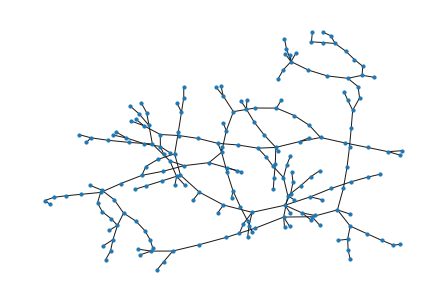

In [19]:
# Quick visualization
nx.draw(g, with_labels = False, node_size=10)

### Network Visualization and Measures

In [20]:
centrality_dgr = nx.degree_centrality(g)
centrality_eigen = nx.eigenvector_centrality_numpy(g, weight='WEIGHT')
centrality_between = nx.betweenness_centrality(g, weight='WEIGHT')

In [21]:
nx.set_node_attributes(g, centrality_dgr, 'centrality_dgr')
nx.set_node_attributes(g, centrality_eigen, 'centrality_eigen')
nx.set_node_attributes(g, centrality_between, 'centrality_between')

In [22]:
nd_attrb = node_attributes_df.to_dict('index')

In [23]:
nx.set_node_attributes(g, nd_attrb)

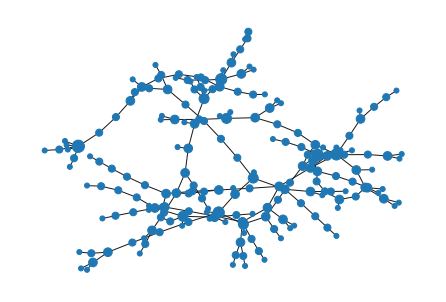

In [24]:
# Degree centrality
nx.draw(g, with_labels = False, node_size=[v * 5000 for v in centrality_dgr.values()])

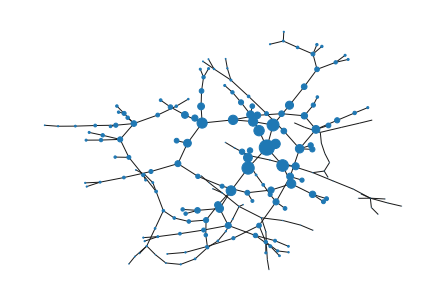

In [25]:
# Eigenvalue centrality
nx.draw(g, with_labels = False, node_size=[v * 500 for v in centrality_eigen.values()])

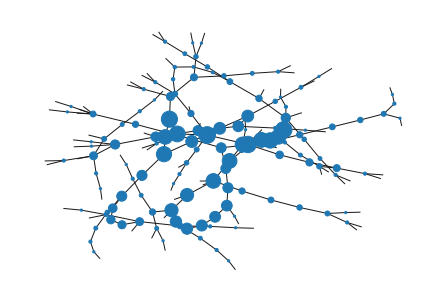

In [26]:
# Betweenness centrality
nx.draw(g, with_labels = False, node_size=[v * 500 for v in centrality_between.values()])

## **Further Visualization**

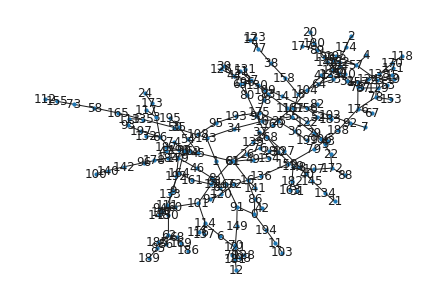

In [27]:
nx.draw(g, with_labels = True, node_size=10)

In [28]:
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.1 which is incompatible.


In [29]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# Create and save a layout.
g_layout = nx.layout.spring_layout(g) 
g_plot = hv.Graph.from_networkx(g, g_layout).opts(tools=['hover'], node_color='community')
labels = hv.Labels(g_plot.nodes, ['x', 'y'], 'index')

In [31]:
from holoviews.operation.datashader import datashade, bundle_graph
bundled = bundle_graph(g_plot)

In [32]:
show(hv.render(bundled * labels.opts(text_font_size='6pt', text_color='white', bgcolor='gray')))

bokeh.core.validation.check - ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "community", key "hatch_color" value "community" [renderer: GlyphRenderer(id='1222', ...)]
